In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [2]:

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
        #print(output_data)
    return output_data

In [3]:
# load the dataset
data = pd.read_csv('/content/Acetaminophen_mixture_CNN_Binary.csv', index_col=0)
data = pd.DataFrame(data)
df = pd.DataFrame()
data.drop(['label_name'], axis=1, inplace=True)
data.rename(columns={'Unnamed: 0': 'id'},inplace=True)
y = data['label']
X = data.drop(['label'],axis=1)
X = X.values[:,0:]
X = snv(X)
X = pd.DataFrame(X)
print((X.shape))
#X = X.values.reshape(900,32,32)
for i in range(227,1024,1):
  X.insert(loc=i, column=i, value=0)
print((X.shape))

(900, 227)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if self.run_code(code, result):


(900, 1024)


(32, 32)


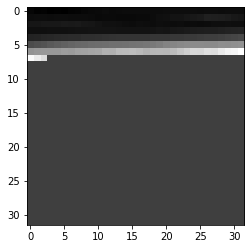

In [4]:
plot = X.values.reshape(900,32,32)
sample_plot =plot[0]
print(sample_plot.shape)
plt.imshow(sample_plot,cmap='gray')
plt.show()

In [5]:
# fit the keras model on the dataset
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

X_train = X_train.values.reshape(X_train.shape[0],32,32,1).astype('float32')
X_test= X_test.values.reshape(X_test.shape[0],32,32,1).astype('float32')
print(X_train.shape)

(720, 32, 32, 1)


In [6]:


# Define Model

tf.keras.metrics.RootMeanSquaredError(
    name="root_mean_squared_error", dtype=None
)
early_stopping = EarlyStopping(
    #monitor='val_accuracy', 
    monitor='loss',
    patience=0, 
    #min_delta=0.001, 
    mode='max'
)
n_timesteps = X_train.shape[1] 
n_features  = X_train.shape[2]  

model = keras.Sequential()

model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(keras.layers.AveragePooling2D())

model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.AveragePooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=256, activation='relu'))

model.add(keras.layers.Dense(units=84, activation='relu'))

#model.add(keras.layers.Dense(units=1, activation = 'relu'))
model.add(keras.layers.Dense(units=1))

model.compile(loss='mse', optimizer='adam', metrics=['mse',tf.keras.metrics.RootMeanSquaredError()])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               1

In [8]:
history = model.fit(X_train, y_train, epochs=20,verbose=1)

Epoch 1/20
23/23 [==============================] - 2s 31ms/step - loss: 0.1649 - mse: 0.1649 - root_mean_squared_error: 0.4061
Epoch 2/20
23/23 [==============================] - 1s 31ms/step - loss: 0.1013 - mse: 0.1013 - root_mean_squared_error: 0.3183
Epoch 3/20
23/23 [==============================] - 1s 33ms/step - loss: 0.0354 - mse: 0.0354 - root_mean_squared_error: 0.1881
Epoch 4/20
23/23 [==============================] - 1s 33ms/step - loss: 0.0162 - mse: 0.0162 - root_mean_squared_error: 0.1271
Epoch 5/20
23/23 [==============================] - 1s 34ms/step - loss: 0.0090 - mse: 0.0090 - root_mean_squared_error: 0.0948
Epoch 6/20
23/23 [==============================] - 1s 28ms/step - loss: 0.0064 - mse: 0.0064 - root_mean_squared_error: 0.0802
Epoch 7/20
23/23 [==============================] - 1s 30ms/step - loss: 0.0057 - mse: 0.0057 - root_mean_squared_error: 0.0758
Epoch 8/20
23/23 [==============================] - 1s 32ms/step - loss: 0.0062 - mse: 0.0062 - root_mea

In [9]:
mse = model.evaluate(X_test, y_test)
print('Accuracy: %.2f',mse)
#print(history.history['mse'])


6/6 [==============================] - 0s 11ms/step - loss: 0.0030 - mse: 0.0030 - root_mean_squared_error: 0.0546
Accuracy: %.2f [0.0029762962367385626, 0.0029762962367385626, 0.054555442184209824]


In [10]:
myst = pd.read_csv('/content/Mystery_testing_data.csv', index_col=0)
myst = pd.DataFrame(myst)
predictions =[]
myst_predictions = pd.DataFrame(myst["label_name"])
myst.drop(['label_name'], axis=1, inplace=True)

myst_actual = pd.read_csv('/content/Mystery_labels.csv')
myst_actual = myst_actual['Actual ']
# Applying SNV to myst data
myst = myst.values[:,0:]
myst = snv(myst)
myst = pd.DataFrame(myst)
for i in range(227,1024,1):
  myst.insert(loc=i, column=i, value=0)
print((X.shape))
myst= myst.values.reshape(myst.shape[0],32,32,1).astype('float32')
preds = model.predict(myst)
#print(preds)
se = pd.Series(preds.tolist())
#print(se.values)
#myst_predictions.insert(loc=0, column='predictions', value=[sum(se.values)/len(se.values)])
#myst_predictions.insert(loc=1, column='predictions', value=se.values)
for i in range(0, 100):
  #myst_predictions.insert(loc=1, column='molar_mass', value=se[i].values)
  predictions.append((sum(se[i])/len(se[i])))
#print(myst_predictions)
myst_predictions.insert(loc=1, column='predictions', value=predictions)

#myst['class_label'] = [1 if x > 0.5 else 0 for x in myst['predictions']]
#myst_predictions.insert(loc=2, column='Class Name', value=se.values)

myst_predictions.to_csv('/content/Mystery_Prediction_2DCNN_data_binary.csv')

# Evaluate model
mse = model.evaluate(myst, myst_actual)
print('Mean Squared Error!',mse)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if self.run_code(code, result):


(900, 1024)
4/4 [==============================] - 0s 9ms/step - loss: 0.1192 - mse: 0.1192 - root_mean_squared_error: 0.3453
Mean Squared Error! [0.11924833059310913, 0.11924833059310913, 0.34532350301742554]


In [11]:
#Predicting Ternary Samples Data
data = pd.read_csv('/content/ternary_samples.csv', index_col=0)
data = pd.DataFrame(data)
ternary_predictions = pd.DataFrame()

ternary_predictions["label_name"] =data["label_name"]
ternary_predictions['Actual'] = data['label']

data.drop(['label_name'], axis=1, inplace=True)
data.rename(columns={'Unnamed: 0': 'id'},inplace=True)

y = data['label']
X = data.drop(['label'],axis=1)
X = X.values[:,0:]
X = snv(X)
X = pd.DataFrame(X)

for i in range(227,1024,1):
  X.insert(loc=i, column=i, value=0)


ternary= X.values.reshape(X.shape[0],32,32,1).astype('float32')
preds = model.predict(ternary)
#print(preds)
se = pd.Series(preds.tolist())
ternary_predictions.insert(loc=0, column='predictions', value=se.values)
#Saving results
ternary_predictions.to_csv('/content/Ternary_Prediction_2DCNN.csv')

# Evaluate model
mse = model.evaluate(ternary, y)
print('Mean Squared Error!',mse)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if self.run_code(code, result):


13/13 [==============================] - 0s 10ms/step - loss: 0.0030 - mse: 0.0030 - root_mean_squared_error: 0.0551
Mean Squared Error! [0.0030402191914618015, 0.0030402191914618015, 0.055138181895017624]


In [12]:
#Predicting Tylenol Data
data = pd.read_csv('tylenol_topcare_samples.csv', index_col=0)
data = pd.DataFrame(data)
ternary_predictions = pd.DataFrame()

ternary_predictions["label_name"] =data["label_name"]


data.drop(['label_name'], axis=1, inplace=True)
data.rename(columns={'Unnamed: 0': 'id'},inplace=True)

X = data.values[:,0:]
X = snv(X)
X = pd.DataFrame(X)

for i in range(227,1024,1):
  X.insert(loc=i, column=i, value=0)

ternary= X.values.reshape(X.shape[0],32,32,1).astype('float32')
preds = model.predict(ternary)
#print (preds)

se = pd.Series(preds.tolist())
ternary_predictions.insert(loc=0, column='predictions', value=se.values)
#Saving results
ternary_predictions.to_csv('/content/Tylenol_Prediction_LeNet_2DCNN.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if self.run_code(code, result):
